# Hiragana Recognition
## Aimed to support Japanese Language Learning
The Japanese language consists of 3 writing systems, Hirgana, Katakana and Kanji. In this notebook, we will implement a Multi-Layered Perceptron algorithm that will be able to recognize handwritten Hiragana characters.

We first import the necessary modules.

In [2]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

### Loading in data

We first load in the necessary dataset for training. The dataset is quite insufficient, however, with only 100 images per class (46 classes), we will proceed with this for the time being.

In [16]:
train_dir = '/Users/krishteee/.cache/kagglehub/datasets/farukece/handwritten-japanese-hiragana-characters/versions/1/hiragana'
test_dir = '/Users/krishteee/.cache/kagglehub/datasets/farukece/handwritten-japanese-hiragana-characters/versions/1/test'

batch_size = 20

train_transform = transforms.Compose([  transforms.RandomRotation(30),
                                        transforms.Resize(50),
                                        transforms.CenterCrop(45),
                                        transforms.ToTensor()])

test_transform = transforms.Compose([   transforms.Resize(50),
                                        transforms.CenterCrop(45),
                                        transforms.ToTensor()])

train_set = datasets.ImageFolder(train_dir, transform = train_transform)
test_set = datasets.ImageFolder(test_dir, transform = test_transform)

valid_split = 0.2
train_size = len(train_set) #4600

indices = list(range(train_size))
np.random.shuffle(indices)

valid_size = int(np.floor(valid_split * train_size))

train_indices = indices[valid_size: ]
valid_indices = indices[: valid_size]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler = valid_sampler)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

### Visualizing our data

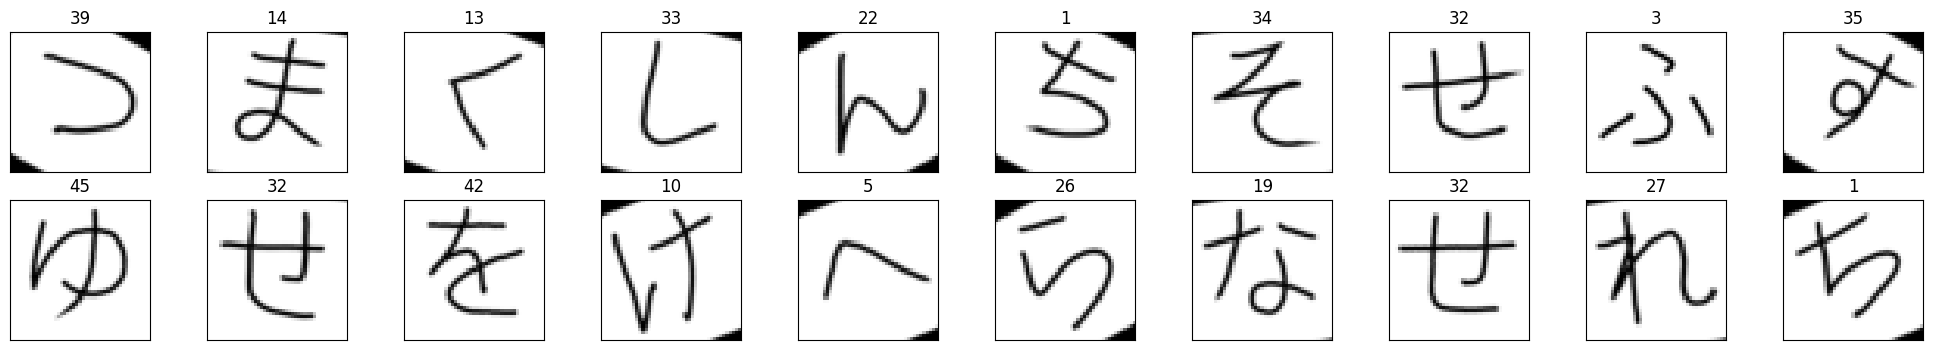

In [38]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx][0]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))
plt.show()

### Defining Neural Network Architecture

With brief search online, seems like most people are using CNNs for Japanese, let's see how bad (or how good) a simple MLP is then.

In [49]:
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6075, 1200)
        self.fc2 = nn.Linear(1200, 512)
        self.fc3 = nn.Linear(512, 46)

        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=6075, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=46, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [50]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

### Training our Network

We will run the computation on the GPU for acceleration, since I am using a Mac, I will be running on my Mac GPU 'MPS'.
I will train my network for 50 epochs, while performing validation at each epoch to keep track of my validation loss, saving the model whenever I reach a new low for my validation loss. This allows me to get the lowest possible validation loss without worry of overfitting as I run through too many epochs.

In [51]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)


epochs = 50

valid_loss_min = np.inf

for e in range(epochs):

    train_loss = 0
    valid_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    else:
        with torch.no_grad():
            model.eval()
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                valid_loss += loss.item()
            model.train()
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))

    # Checks if current valid_loss is lower than current valid_loss_min, if yes, our model just got better --> save model
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))

        torch.save(model.state_dict(), 'hiragana.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.823818 	Validation Loss: 3.791470
Validation loss decreased (inf --> 3.791470).  Saving model ...
Epoch: 2 	Training Loss: 3.768465 	Validation Loss: 3.721058
Validation loss decreased (3.791470 --> 3.721058).  Saving model ...
Epoch: 3 	Training Loss: 3.640651 	Validation Loss: 3.512464
Validation loss decreased (3.721058 --> 3.512464).  Saving model ...
Epoch: 4 	Training Loss: 3.315873 	Validation Loss: 2.961220
Validation loss decreased (3.512464 --> 2.961220).  Saving model ...
Epoch: 5 	Training Loss: 2.724678 	Validation Loss: 2.272852
Validation loss decreased (2.961220 --> 2.272852).  Saving model ...
Epoch: 6 	Training Loss: 2.143393 	Validation Loss: 1.858329
Validation loss decreased (2.272852 --> 1.858329).  Saving model ...
Epoch: 7 	Training Loss: 1.536663 	Validation Loss: 1.238137
Validation loss decreased (1.858329 --> 1.238137).  Saving model ...
Epoch: 8 	Training Loss: 1.051598 	Validation Loss: 0.730372
Validation loss decreased (1.23813

###  Load the Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('hiragana.pt'))

Network(
  (fc1): Linear(in_features=6075, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=46, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [80]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(46))
class_total = list(0. for i in range(46))

model.eval() # prep model for evaluation

data_loader = valid_loader

for data, target in data_loader:

    data, target = data.to(device), target.to(device)
    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(batch_size):
        if(target.shape[0] == 2):
            break
        label = target[i].item()
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(data_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(46):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.006805

Test Accuracy of     0: 92% (13/14)
Test Accuracy of     1: 100% (18/18)
Test Accuracy of     2: 100% (20/20)
Test Accuracy of     3: 100% (21/21)
Test Accuracy of     4: 100% (18/18)
Test Accuracy of     5: 100% (19/19)
Test Accuracy of     6: 100% (21/21)
Test Accuracy of     7: 100% (27/27)
Test Accuracy of     8: 100% (23/23)
Test Accuracy of     9: 89% (17/19)
Test Accuracy of    10: 100% (23/23)
Test Accuracy of    11: 95% (21/22)
Test Accuracy of    12: 100% (22/22)
Test Accuracy of    13: 100% (21/21)
Test Accuracy of    14: 100% (18/18)
Test Accuracy of    15: 100% (21/21)
Test Accuracy of    16: 100% (19/19)
Test Accuracy of    17: 100% (15/15)
Test Accuracy of    18: 100% (19/19)
Test Accuracy of    19: 100% (17/17)
Test Accuracy of    20: 100% (18/18)
Test Accuracy of    21: 100% (21/21)
Test Accuracy of    22: 100% (20/20)
Test Accuracy of    23: 100% (21/21)
Test Accuracy of    24: 95% (19/20)
Test Accuracy of    25: 90% (18/20)
Test Accuracy of    26

### Evaluation

When doing testing, it can be seen that we get an overall test accuracy of 98% for the validation set, and yet only 35% for our own test set, which was handwritten by me.
This suggests that the model is able to generalize to the validation set, but not my handwritten test set, i.e. the training set and my test set have prominent differences.
There are two factors leading to such a problem: 

* **Not enough data** for the training set, hence it is not diverse or comprehensive enough for the model to generalize to my handwriting upon training (explains why it performs well on the validation set, which it also has not seen before, but not on my data). In other words, **overfitting**!

* My Japanese handwriting is abominable.